# 1. U-Net Model - from scratch

## 1.1. Model Setup

In [1]:
import torch
import albumentations as A
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from model import UNET
import cv2
from utils import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy,
)

# Hyperparameters etc.
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 5
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

In [2]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, desc="Training", unit="batch")
    train_losses = []

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    train_loss = sum(train_losses) / len(train_losses)
    return train_loss


In [3]:
# Defining the model, optimizer and loss function
model = UNET(in_channels=3, out_channels=37).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [4]:
# Defining transformations for model
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=1.0),
        A.Rotate(limit=35, p=0.2, border_mode=cv2.BORDER_CONSTANT, value=255),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomResizedCrop(p=0.1,height=IMAGE_HEIGHT, width=IMAGE_WIDTH,),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=1.0),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
    ],
)

In [5]:
# Get datasets and data loaders
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

scaler = torch.cuda.amp.GradScaler()

## 1.2. Model Training

In [6]:
# Set up loss lists
train_losses = []
validation_losses = []
validation_miou = []
validation_iou_all = []
validation_accu = []

In [7]:
# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"=> Training model at Epoch {epoch+1}")
    loss_t = train_fn(train_loader, model, optimizer, loss_fn, scaler)
    train_losses.append(loss_t)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    loss_v, accuracy_v, miou_v, iou_v = check_accuracy(val_loader, model, val_dataset, epoch+1, loss_fn,  device=DEVICE, save_images=True, save_batch=10)
    validation_losses.append(loss_v)
    validation_miou.append(miou_v)
    validation_iou_all.append(iou_v)
    validation_accu.append(accuracy_v)
    print("\n")

=> Training model at Epoch 1


Training: 100%|██████████| 414/414 [01:23<00:00,  4.94batch/s, loss=1.62]


=> Saving checkpoint
=> Checking accuracy


Validation: 100%|██████████| 104/104 [00:30<00:00,  3.44batch/s]


Got 15676503/31792425 with acc 49.31
MUoI score: 0.06


=> Training model at Epoch 2


Training: 100%|██████████| 414/414 [01:14<00:00,  5.54batch/s, loss=2.15]


=> Saving checkpoint
=> Checking accuracy


Validation: 100%|██████████| 104/104 [00:28<00:00,  3.61batch/s]


Got 16068688/31792425 with acc 50.54
MUoI score: 0.07


=> Training model at Epoch 3


Training: 100%|██████████| 414/414 [01:15<00:00,  5.45batch/s, loss=1.92]


=> Saving checkpoint
=> Checking accuracy


Validation: 100%|██████████| 104/104 [00:27<00:00,  3.79batch/s]


Got 16873742/31792425 with acc 53.07
MUoI score: 0.07


=> Training model at Epoch 4


Training: 100%|██████████| 414/414 [01:15<00:00,  5.51batch/s, loss=1.36]


=> Saving checkpoint
=> Checking accuracy


Validation: 100%|██████████| 104/104 [00:26<00:00,  3.96batch/s]


Got 17271677/31792425 with acc 54.33
MUoI score: 0.08


=> Training model at Epoch 5


Training: 100%|██████████| 414/414 [01:14<00:00,  5.58batch/s, loss=1.53]


=> Saving checkpoint
=> Checking accuracy


Validation: 100%|██████████| 104/104 [00:26<00:00,  3.91batch/s]

Got 17031451/31792425 with acc 53.57
MUoI score: 0.08




## 1.3. Model Evaluation

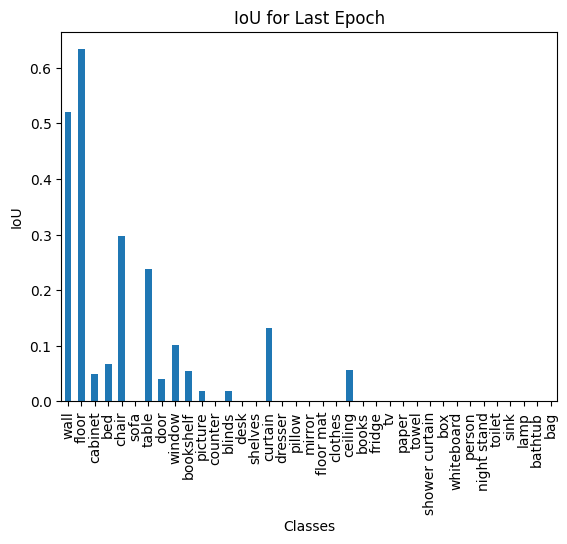

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(validation_iou_all, columns=val_dataset._class_names)
# Plot the values from the last row in a bar chart
last_row = df.iloc[-1]
last_row.plot(kind='bar', xlabel='Classes', ylabel='IoU', title='IoU for Last Epoch')
plt.show()

In [ ]:
# Check accuracy on test set
_ = check_accuracy(test_loader, model, test_dataset, 'test', loss_fn, device=DEVICE, save_images=True)

=> Checking accuracy


Validation: 100%|██████████| 2067/2067 [03:14<00:00, 10.64batch/s]

Got 181277060/400817016 with acc 45.23
MUoI score: 0.16


(nan,
 45.22688727366804,
 0.1605328768075738,
 array([0.38925847, 0.42183675, 0.        , 0.        , 0.165363  ,
        0.        , 0.0578543 , 0.        , 0.01834927, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]))